# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

# Data import

In [2]:
features_df = pd.read_csv("features_train.csv")

In [3]:
classes_df = pd.read_csv("classes_train.csv")

# Data Exploration

In [4]:
data_df = pd.concat([features_df, classes_df], axis=1)

In [5]:
classes_df.value_counts()

is_bot
0         1800
1          600
dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df, classes_df, test_size=0.2, random_state=0)

In [8]:
X_test.to_csv('features_test.csv')
y_test.to_csv('classes_test.csv')

In [10]:
%%time
model = RandomForestClassifier()
model.fit(X_train, y_train)

<timed exec>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: total: 656 ms
Wall time: 770 ms


RandomForestClassifier()

In [11]:
predictions = model.predict(X_test)

RandomForest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       369
           1       0.98      0.98      0.98       111

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480

F1-score:  0.9819819819819819


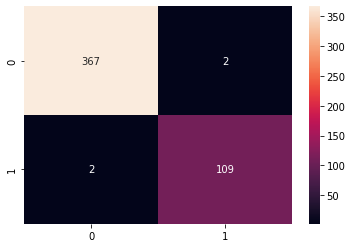

In [12]:
print("RandomForest")
print(classification_report(y_test, predictions))
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d")
print("F1-score: ", f1_score(y_test, predictions))

<AxesSubplot:>

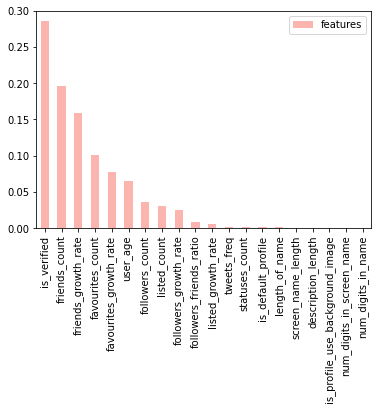

In [13]:
feature_importances = pd.DataFrame(data=model.feature_importances_, index=features_df.columns, columns=['features'])
feature_importances.sort_values(by='features', ascending=False, inplace=True)
feature_importances.plot(kind='bar', colormap='Pastel1')

Были выбраны 10 самых значимых признаков для дальнейшего использования в классификации.

In [14]:
feature_importances.index[:10]

Index(['is_verified', 'friends_count', 'friends_growth_rate',
       'favourites_count', 'favourites_growth_rate', 'user_age',
       'followers_count', 'listed_count', 'followers_growth_rate',
       'followers_friends_ratio'],
      dtype='object')

# Classification

In [4]:
new_features_df = features_df[['is_verified', 'friends_count', 
                               'friends_growth_rate','favourites_count', 
                               'favourites_growth_rate', 'user_age',
                               'followers_count', 'listed_count', 
                               'followers_growth_rate', 'followers_friends_ratio']]

In [5]:
# Split data to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    new_features_df, classes_df, test_size=0.2, random_state=0)

In [6]:
X_train.shape

(1920, 10)

In [11]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1
print(n_jobs)

3


In [12]:
%%time
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2, 40)],
    'max_features': ['log2', 'sqrt'], 
    'random_state': [23],
}
b_search = BayesSearchCV( 
    estimator=RandomForestClassifier(),
    scoring='precision',
    search_spaces=parameters,
    cv=3,
    n_iter=120,
    n_jobs=n_jobs
)

b_search.fit(X_train, y_train)
print('Best parameters: ', b_search.best_params_)
print("Best score: ", b_search.best_score_)

Best parameters:  OrderedDict([('criterion', 'entropy'), ('max_depth', 29), ('max_features', 'log2'), ('random_state', 23)])
Best score:  0.9939270756343928
CPU times: total: 6min 45s
Wall time: 8min 3s


In [15]:
model_best = b_search.best_estimator_
print(model_best)

RandomForestClassifier(criterion='entropy', max_depth=29, max_features='log2',
                       random_state=23)


In [16]:
with open('./model_searched.pkl', 'wb') as f:
    pickle.dump(b_search.best_estimator_, f)

In [17]:
predictions = model_best.predict(X_test)

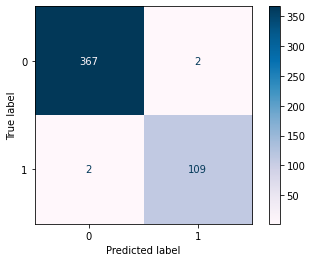

In [18]:
conf_matrix = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='PuBu')

In [19]:
print(classification_report(y_test, predictions))
print("F1-score: ", f1_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("Precision: ", precision_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       369
           1       0.98      0.98      0.98       111

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480

F1-score:  0.9819819819819819
Recall:  0.9819819819819819
Precision:  0.9819819819819819


При подборе гиперпараметров максимизировалась метрика precision для снижения вероятности ложного обнаружения. Вероятность пропуска бота на уровне не выше 0.03 (98% точности).